# SequentialForwardSelection Алгоритм:
1. Фиксируем небольшое число признаков N(aka n_start_feats).
2. Перебираем все комбинации по N(aka n_start_feats) признаков, выбираем лучшую комбинацию(лучшей комбинацей считаем ту, которая доставляет МИНИМУМ валидационному критерию).
3. Перебираем комбинации из N+1 признаков так, что предыдущая лучшая комбинация признаков зафиксирована, а перебирается только новый признак(опять же, лучшим N+1ым признаком считаем тот, который доставляет МИНИМУМ валидационному критерию).
4. Таким образом перебираем, пока не упремся в максимально допустимое число признаков (k_features (aka n_features_to_select)) или пока качество модели не перестанет значимо расти.

In [1]:
from sklearn.model_selection import cross_val_score
from itertools import combinations
import numpy as np

def cv_criterion(estimator, X, y, **params):
    return -cross_val_score(estimator, X, y, **params).mean()

class SFS:
    """Feature selection with sequential forward selection.
    
    Parameters
    ----------
    estimator : object
        A supervised learning estimator which used for evaluating validation criterion value, 
        so it must be consistent with `fit` method parameter `valid_criterion.
        
    Attributes
    ----------
    estimator_ : object.
    
    n_features : int
        The number of selected features.
        
    support : array of shape [n_features]
        The column numbers of selected features.
    
    ranking : array of shape [n_features]
        The feature ranking, such that ``ranking[i]`` corresponds to the
        ranking position of the i-th feature. Selected (i.e., estimated
        best) features are assigned rank 1.
    
    valid_criterion_history : python list.
        History of validation criterion values.
    """
    def __init__(self, estimator):
        self.estimator = estimator
        self.n_features = 0
        self.support = np.array([])
        self.ranking = np.array([])
        self.valid_criterion_history = []
        
    def fit(self, X, y, n_start_feats=1, tol=1e-3, n_iter_no_change=3, 
            n_features_to_select=None, valid_criterion=cv_criterion, 
            **valid_criterion_params):
        """Fit the SFS model.
        
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples.
            
        y : array-like of shape (n_samples,)
            The target values.
            
        n_start_feats : int, default=1
            The number of features getting by fullsearch on first stage of the algorithm.
            (aka N from algorithm discription).
            
        tol : float, default=1e-3
            The stopping criterion. If it is not None, selection will stop
            when (global_best_crit_value - best_crit_value < tol) for `n_iter_no_change` consecutive 
            selectiong of new feature. After that `support` and `n_features` will return to 
            `n_iter_no_change` iterations back.
            
        n_iter_no_change : int, default=3
            Number of iterations with no improvement to wait before early stopping.
        
        n_features_to_select : int or None (default=None)
            The number of features to select(aka k_features from algorithm discription).
            
        valid_criterion : object (default=cv_criterion)
            The validaton criterion which considering as estimation error, so greater is worse.
        
        **valid_criterion_params : dict
            Additional validation criterion parameters.
        """
        self.ranking = np.full(X.shape[1], X.shape[1])
        feat_cols = np.arange(X.shape[1])
        rank = 1
        global_best_crit_value = np.inf
        
        # FullSearch of best `n_start_feats` features
        for feats in combinations(feat_cols, n_start_feats):
            crit_value = valid_criterion(self.estimator, X[:, feats], y, 
                                         **valid_criterion_params)
            
            if crit_value < global_best_crit_value:
                self.support = np.array(feats)
                global_best_crit_value = crit_value
        
        self.n_features = n_start_feats
        self.ranking[self.support] = rank
        rank += 1
        self.valid_criterion_history.append(global_best_crit_value)
        
        if tol is not None: 
            iter_no_change = 0
            best_support = self.support
        
        # Searching new best features one by one 
        # while Stopping Criterions
        for _ in range(n_start_feats, X.shape[1]):
            best_feats = None
            best_crit_value = np.inf
            
            for feat in np.delete(feat_cols, self.support):
                feats = np.hstack((self.support, feat))
                crit_value = valid_criterion(self.estimator, X[:, feats], y, 
                                             **valid_criterion_params)
                
                if crit_value < best_crit_value:
                    best_feats = feats
                    best_crit_value = crit_value
            
            self.n_features += 1
            self.support = best_feats
            self.ranking[self.support[-1]] = rank
            rank += 1
            self.valid_criterion_history.append(best_crit_value)
            
            # Stopping Criterion
            if tol is not None:
                if (global_best_crit_value - best_crit_value) < tol:
                    iter_no_change += 1
                else:
                    iter_no_change = 0
                    best_support = self.support
                
                if best_crit_value < global_best_crit_value: 
                    global_best_crit_value = best_crit_value
                
                if iter_no_change == n_iter_no_change: 
                    self.n_features -= n_iter_no_change
                    self.support = best_support
                    
                    break
            
            # Stopping Criterion
            if n_features_to_select is not None:
                if self.n_features == n_features_to_select:
                    break
        
        return self
                
    
    def transform(self, X):
        return X[:, self.support]
    
    def fit_transform(self, X, y, **fit_params):
        return self.fit(X, y, **fit_params).transform(X)

# Пример: 
### Истинная зависимость: $y_i = 4.0 + 2.5x_i - 6.0x^2_i + \epsilon,\, \, \epsilon \backsim N(0, 1)$
### Предикторы: $x_i = [1, x_i, x^2_i]$
### "Испорченные" предикторы: $\tilde x_i = [x_i, \alpha, 1+3x^6_i, 1, \beta, x^2_i, x_i+\epsilon],
\, \, \alpha, \beta, \epsilon - случайные \, \, величины$

In [17]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [18]:
grid = np.linspace(-1, 1, 100)
weights = np.array([4.0, 2.5, -6.0])
X = np.power(grid.reshape(-1, 1), [0, 1, 2])
y = np.dot(X, weights) + np.random.randn(100)

In [19]:
# Add useless features
X = np.hstack((X[:, 1].reshape(-1, 1),
               np.random.randint(24, size=(100, 1)),
               (X[:, 0]+3*np.power(X[:, 2], 3)).reshape(-1, 1),
               X[:, 0].reshape(-1, 1),
               np.random.exponential(size=(100, 1)),
               X[:, 2].reshape(-1, 1),
               X[:, 1].reshape(-1, 1)+np.random.normal(size=(100, 1))))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

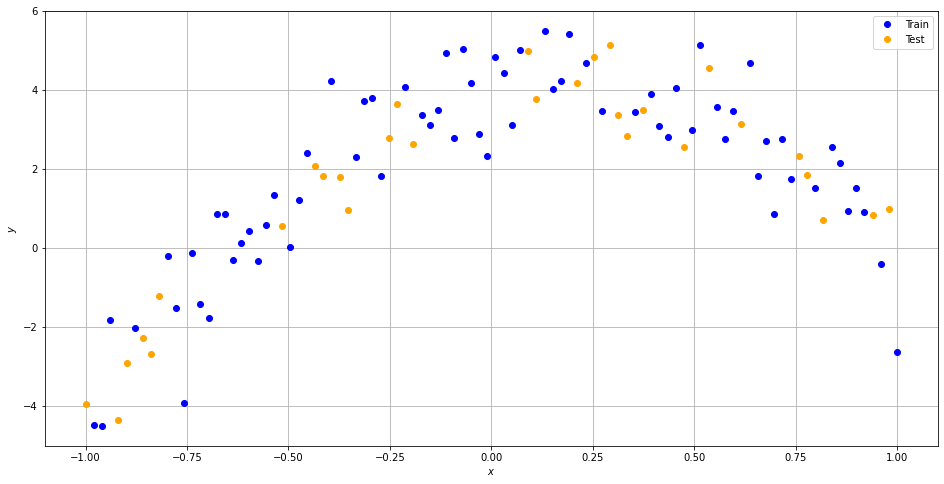

In [21]:
# Graph of Sample
plt.figure(figsize=(16, 8))

plt.plot(X_train[:, 0], y_train, "o", color="blue", label="Train")
plt.plot(X_test[:, 0], y_test, "o", color="orange", label="Test")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True)
plt.legend()

plt.show()

In [22]:
# Fit LinearRegression without SFS
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [23]:
# Weights(should be: [2.5, 0, 0, 4.0, 0, -6.0, 0])
lr.coef_

array([ 2.25002661e+00, -2.94878673e-02, -1.17683136e-01, -4.77395901e-15,
        2.08313424e-01, -6.44594420e+00, -1.51778990e-01])

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

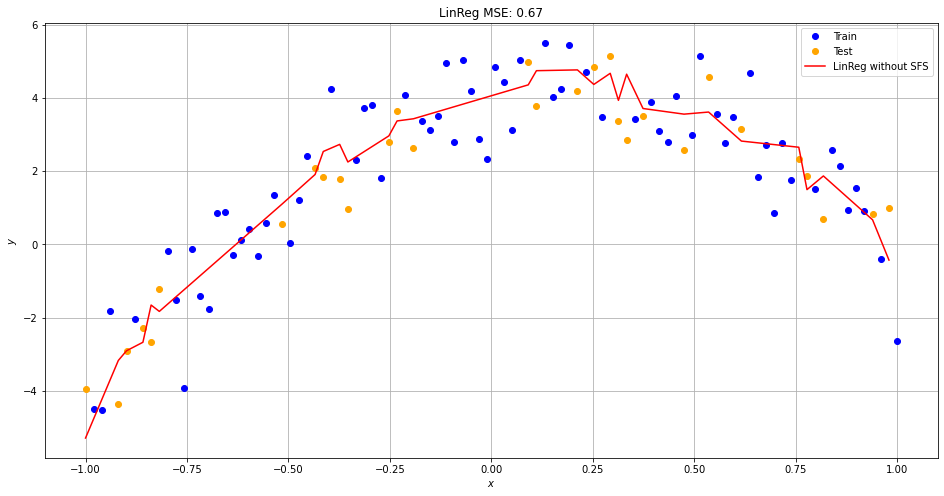

In [25]:
lr_mse = np.round(mean_squared_error(y_test, y_pred), 2)
perm = X_test[:, 0].argsort()

# Graph of predictions without SFS
plt.figure(figsize=(16, 8))

plt.plot(X_train[:, 0], y_train, "o", color="blue", label="Train")
plt.plot(X_test[:, 0], y_test, "o", color="orange", label="Test")
plt.plot(X_test[:, 0][perm], y_pred[perm], color="red", label="LinReg without SFS")

plt.title("LinReg MSE: {}".format(lr_mse))
plt.xlabel("$x$")
plt.ylabel("$y$")

plt.grid(True)
plt.legend()

plt.show()

In [32]:
# Applying SequentialForwardSelection
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

selector = SFS(lr).fit(X_train, y_train, scoring=mse_scorer)
X_train_trans = selector.transform(X_train)
X_test_trans = selector.transform(X_test)

print("Importatn columns: {}".format(selector.support))
print("Ranking: {}".format(selector.ranking))

Importatn columns: [5 0 1]
Ranking: [2 3 7 4 5 1 6]


In [33]:
# Fit LinearRegression after SFS
y_pred = lr.fit(X_train_trans, y_train).predict(X_test_trans)

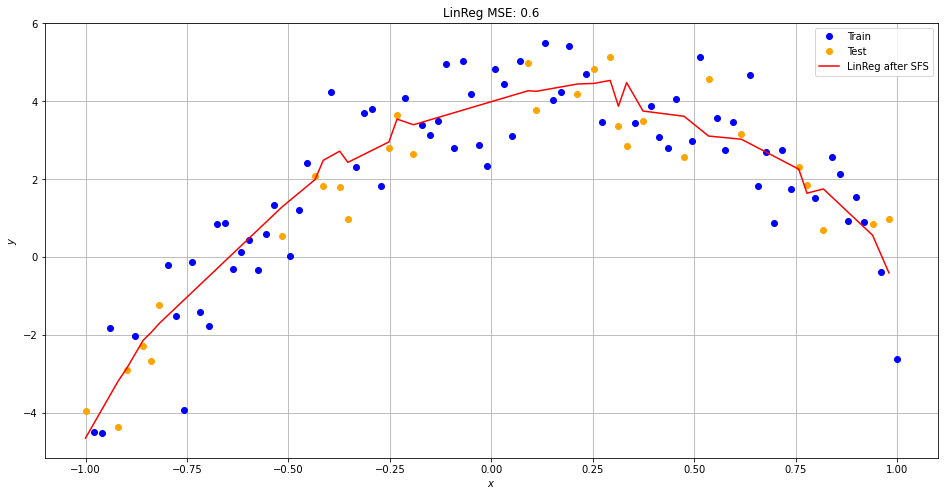

In [34]:
# Graph of prediction after SFS
lr_mse = np.round(mean_squared_error(y_test, y_pred), 2)
perm = X_test_trans[:, 1].argsort()

plt.figure(figsize=(16, 8))

plt.plot(X_train_trans[:, 1], y_train, "o", color="blue", label="Train")
plt.plot(X_test_trans[:, 1], y_test, "o", color="orange", label="Test")
plt.plot(X_test_trans[:, 1][perm], y_pred[perm], color="red", label="LinReg after SFS")

plt.title("LinReg MSE: {}".format(lr_mse))
plt.xlabel("$x$")
plt.ylabel("$y$")

plt.grid(True)
plt.legend()

plt.show()

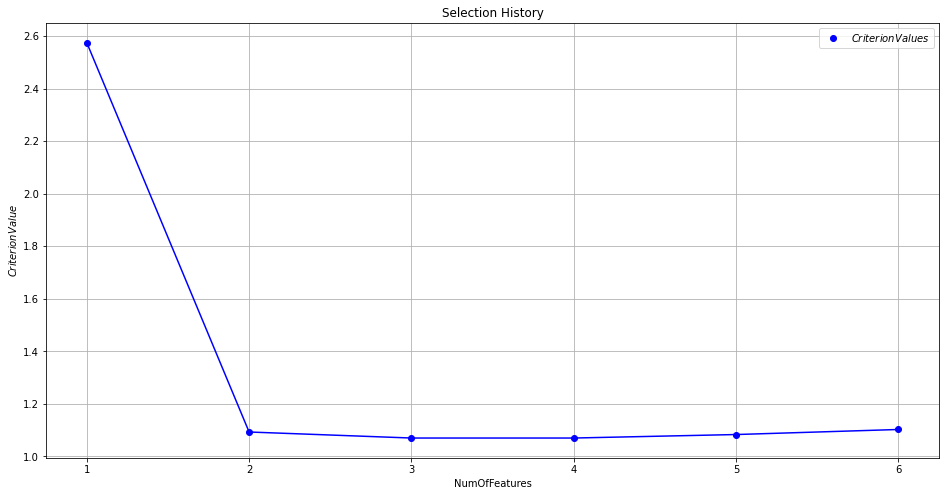

In [35]:
# SFS - Validation Criterion Values vs Features Number graph
fnum = np.arange(1, len(selector.valid_criterion_history)+1)

plt.figure(figsize=(16, 8))

plt.plot(fnum, selector.valid_criterion_history, "o", color="blue", label="$Criterion Values$")
plt.plot(fnum, selector.valid_criterion_history, color="blue")

plt.title("Selection History")
plt.xlabel("Num of Features")
plt.ylabel("$Criterion Value$")

plt.grid(True)
plt.legend()

plt.show()